## 데이터 다운로드

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

## 데이터 구조 훑어보기

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


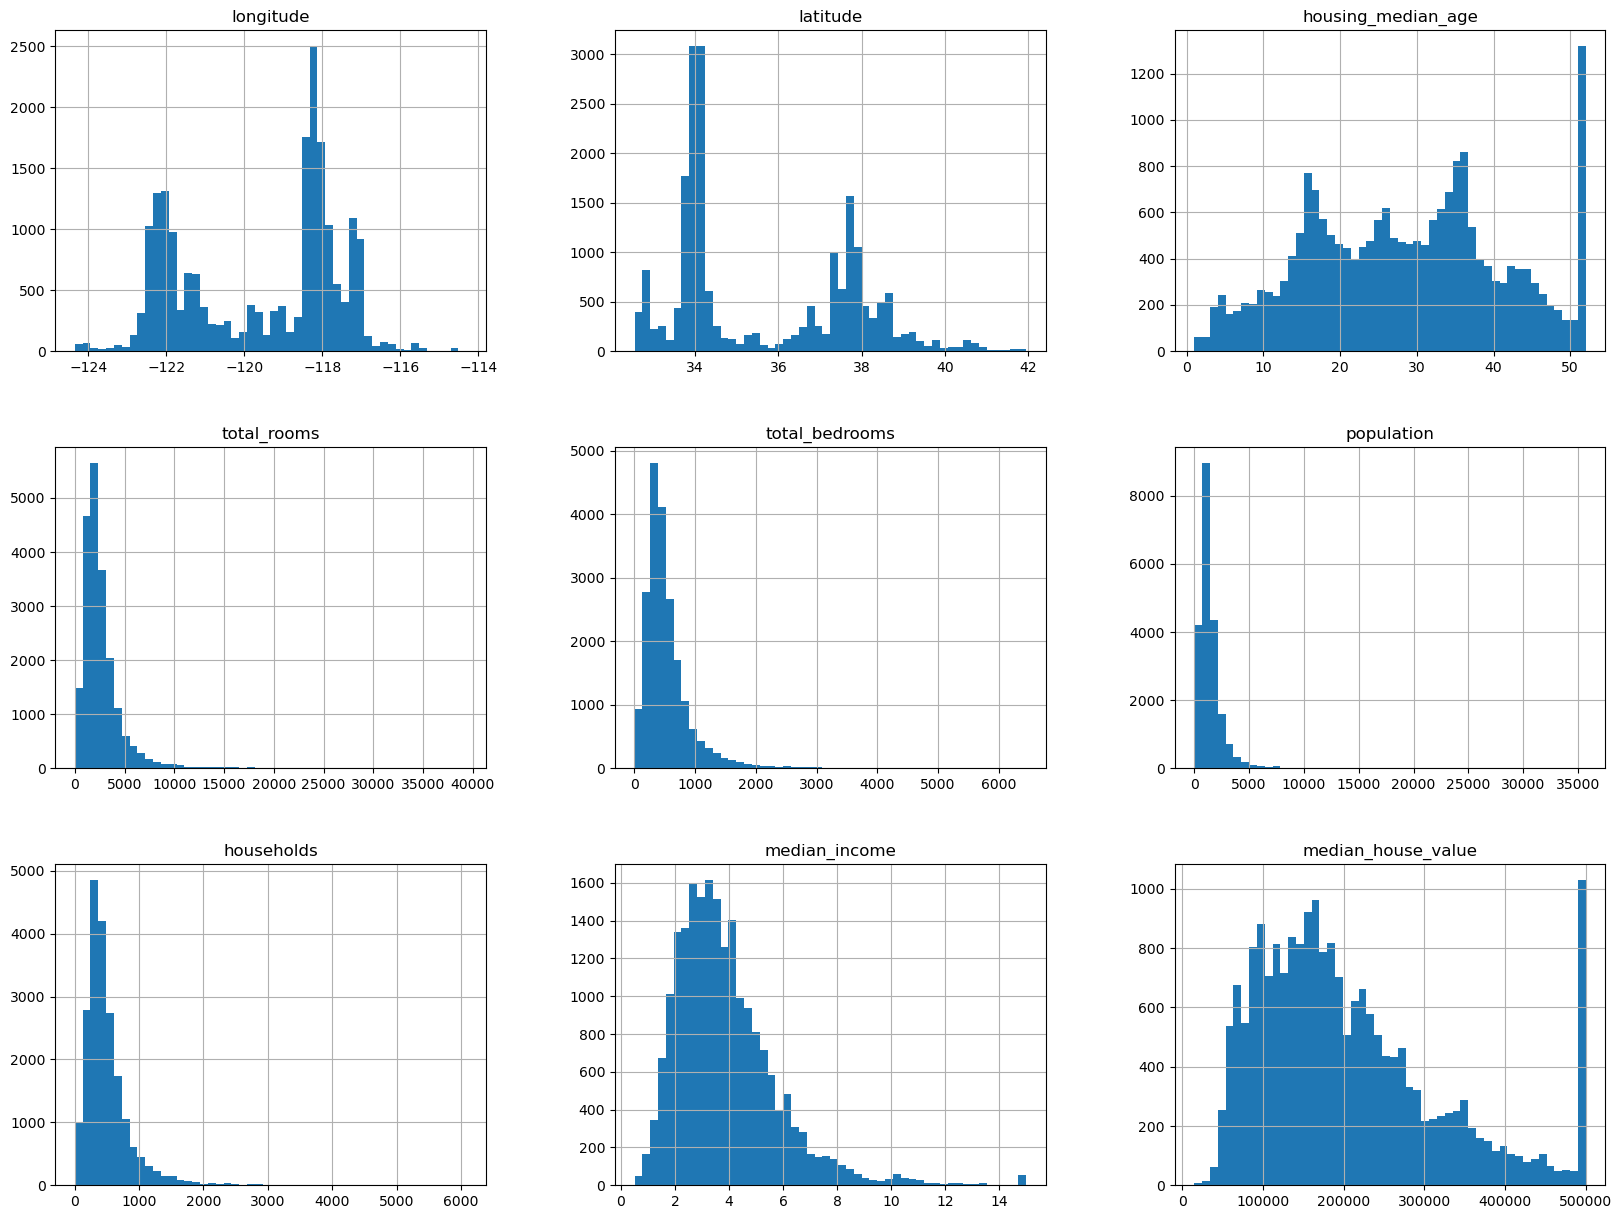

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## 테스트 세트 만들기

In [11]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)

In [15]:
len(train_set)

16512

In [20]:
# 프로그램 재실행 시에도 샘플 유지
# 샘플마다 샘플의 식별자를 사용하여 해시값을 계산, 최대 해시값의 % 보다 작거나 같은 샘플만 테스트로

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 **32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [21]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [22]:
# 위도, 경도를 이용해 고유 식별자를 만들어 분할

housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [24]:
# 사이킷런 사용

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state= 42)

### 무작위 샘플링은 일반적으로는 안전하나, 편향이 생길 가능성 역시 존재

In [25]:
# 계층 샘플링 (카테고리를 대표할 수 있게, 각 계층이 충분히 커야)
# 카테고리를 나눠, 각 카테고리에서 n개씩 샘플링하는 기법이다.

# median_income의 값을 기준으로, 총 5개 카테고리로 자름
# pd.cut = 구간 나누기
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])

In [27]:
housing['income_cat']

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

<Axes: >

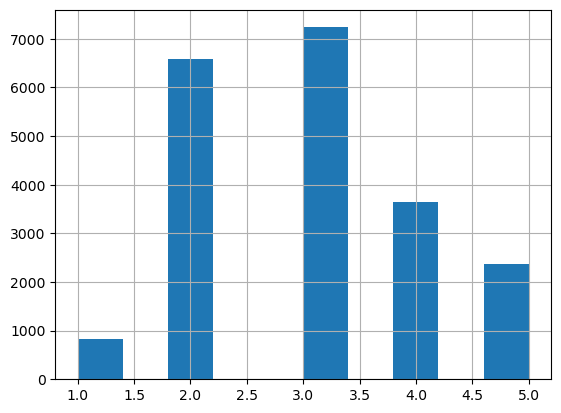

In [26]:
housing['income_cat'].hist()

In [29]:
# 계층적 샘플링 기법 활용

from sklearn.model_selection import StratifiedShuffleSplit
# n_splits = 분할할 <데이터셋의 개수>
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [30]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

# 계층적 샘플링을 이용해 테스트 세트를 만들면, 원본 데이터셋에 있는 카테고리 비율과 유사하게 추출할 수 있다.

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [31]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## 데이터 탐색과 시각화

In [32]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

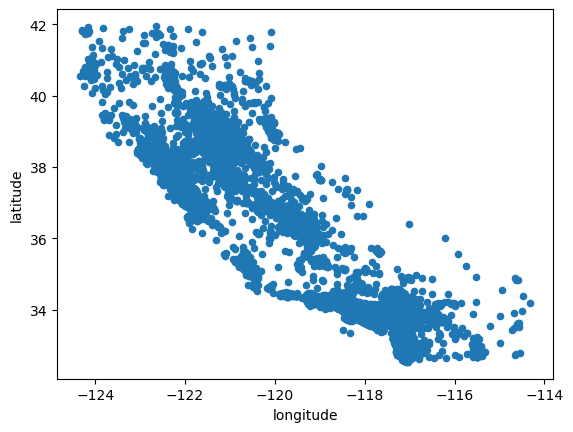

In [33]:
# 산점도
housing.plot(kind='scatter', x='longitude', y='latitude')

<Axes: xlabel='longitude', ylabel='latitude'>

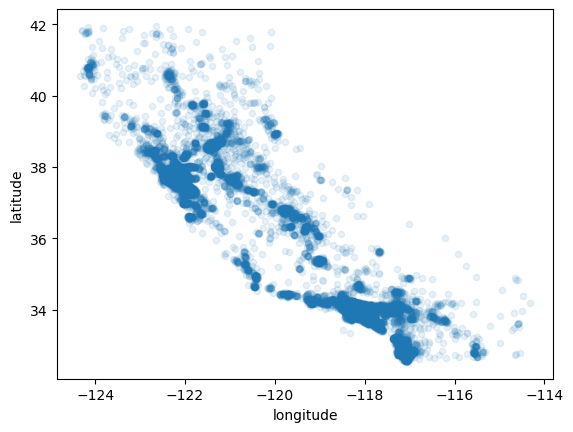

In [36]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

# alpha = 투명도 조절 -> 점들을 투명하게 만들어 많이 뭉쳐있어 진한 부분만 확인할 수 있음

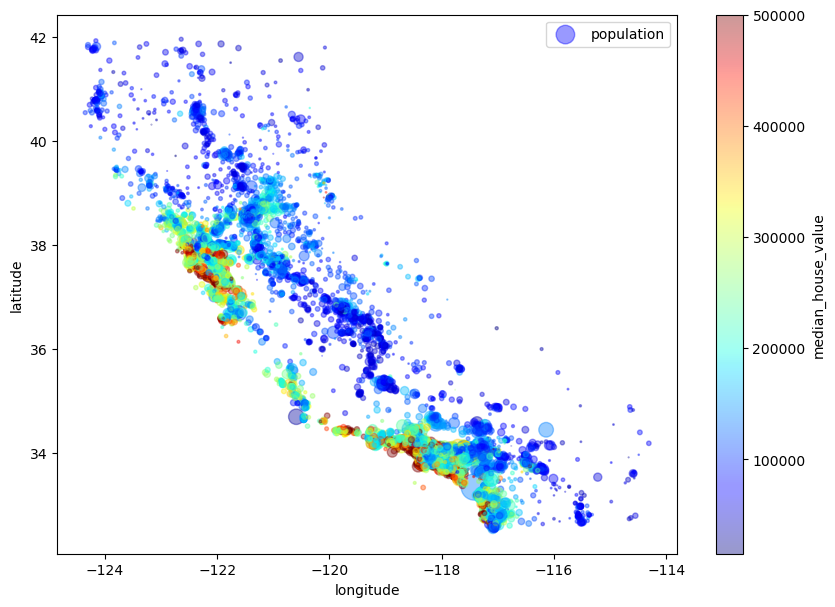

In [42]:
# 시각화 매개변수 조절
# c, cmap = 미리 설정된 color map에 대해, c의 값에 따라 색상을 배정함
# s = 점의 크기 (population / 100에 따라)
# sharex = 여러개의 그래프가 축을 공유하게끔 설정 (이 경우 그래프가 하나라 True False가 같음)

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)
plt.legend()

## 상관관계 조사

In [43]:
# 피어슨 상관계수 확인
# corr 메서드 - 모든 특성 간의 상관계수를 간단히 구할 수 있음

corr_matrix = housing.corr()

C:\Users\DMCCONET\AppData\Local\Temp\ipykernel_22484\2466220658.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [44]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

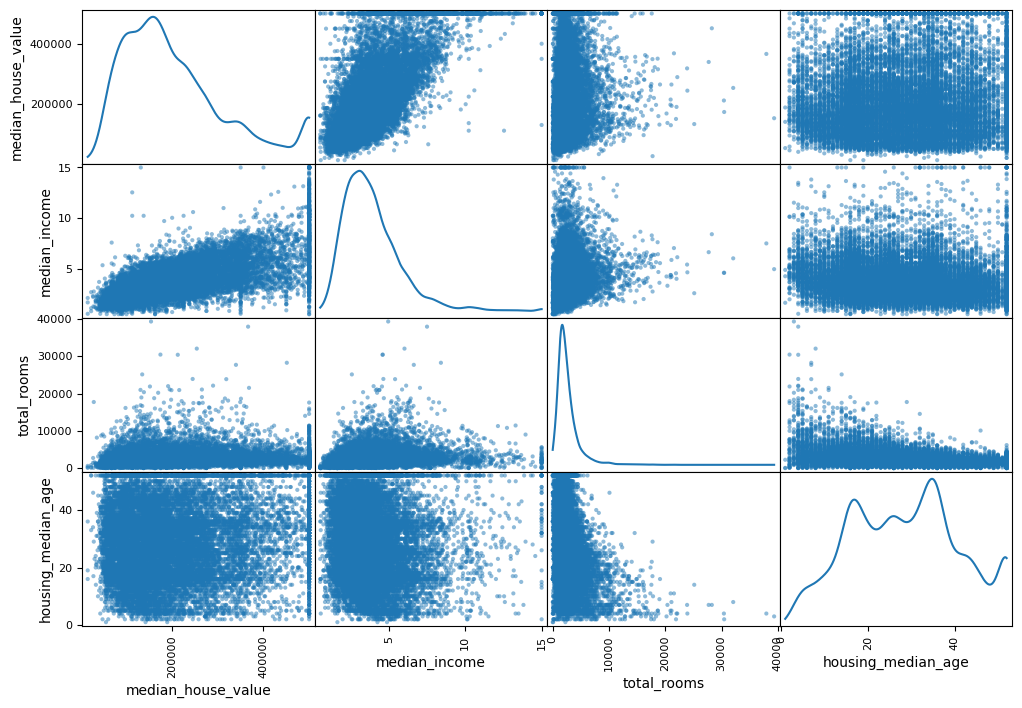

In [46]:
# 특성 사이에 산점도 그리기

from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8), diagonal='kde') 

# diagonal = 자기 자신과의 상관계수는 무조건 1이므로 히스토그램 혹은 커널밀도 그래프를 그리게 됨

<Axes: xlabel='median_income', ylabel='median_house_value'>

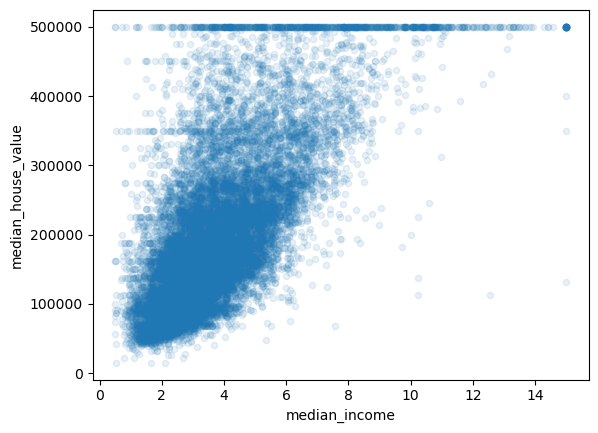

In [47]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

# 수평선 형태의 데이터는? 학습하지 않도록 제거하는 것이 좋음 (제한값에 데이터가 쏠려있으므로)

## 특성 조합

In [48]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [49]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

C:\Users\DMCCONET\AppData\Local\Temp\ipykernel_22484\2905470689.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## 데이터 준비, 정제

In [50]:
# 레이블 분리

housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [51]:
# 데이터 정제 - 1. 결측값 처리
# 결측치 제거, 전체 열 삭제, 결측치 대체

housing.dropna(subset=['total_bedrooms']) # 제거
housing.drop('total_bedrooms', axis=1) # 삭제
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True) # 대체

In [52]:
# 사이킷런 활용 (대체)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [53]:
# 범주형 특성을 제외한 복사본 생성 (중간값 삽입이 불가하므로)
housing_num = housing.drop('ocean_proximity', axis =1)

In [54]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [55]:
# 각 특성의 중간값을 계산하여 statistics_ 속성에 저장 = median().values와 같은 결과

imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [56]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [57]:
# 누락된 값을 학습한 중간값으로 대체
X = imputer.transform(housing_num)

In [59]:
# 다시 데이터프레임으로 되돌리기
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

## 텍스트, 범주형 특성

In [61]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [62]:
# 텍스트를 숫자로 변환 (OrdinalEncoder)
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [63]:
# 카테고리 목록
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [64]:
# ordinal encoder의 문제 - category를 0, 1, 2, 3, 4로 만듦으로써, 카테고리 간 유사성이 있는 것처럼 보이게 착각할 수 있음
# 이것을 해결하기 위해 onehotencoder 사용 [0, 0, 0, 0, 1] 형식

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [65]:
# sparse matrix 객체 배열로 확인
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [66]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 나만의 변환기

In [67]:
# fit, transform, fit_transform 메서드 구현 / TransformerMixin, BaseEstimator 상속하여
# 조합 특성을 추가하는 간단한 변환기

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## 특성 스케일링

In [69]:
# min-max 스케일링과 표준화
# 변환 파이프라인 - 순서가 중요함

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# pipeline은 이름 / 변환기 쌍으로 구성됨
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                        ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [70]:
# ColumnTransformer (범주형, 수치형을 따로 처리하여 융합)
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

# columnTransformer는 튜플로 구성됨 (이름, 변환기, 변환기 적용될 열)
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

## 훈련

In [71]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [72]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print('예측:', lin_reg.predict(some_data_prepared))
print('레이블:', list(some_labels))

예측: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [73]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [74]:
# rmse가 썩 좋은 점수가 아니기 때문에 다른 방법을 사용
# 모델 선택 / 특성 선택 / 규제 감소..

#1. 모델 
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [75]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [76]:
# rmse가 0? 과적합 (과대적합) 의 가능성이 높음

# 교차검증 기능으로 훈련, 평가

from sklearn.model_selection import cross_val_score
# 결정트리 모델로 prepared를 예측한 값과 label(정답)의 값을 10번 교차검증하여 비교
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores) # neg_mean_squared_error를 기준으로 계산하기 위해 -score로 다시 양수 변환

In [77]:
def display_scores(scores):
    print('점수:', scores)
    print('평균:', scores.mean())
    print('표준편차:', scores.std())

display_scores(tree_rmse_scores)

점수: [72113.95769861 71623.5525724  70139.77200652 71783.42508842
 70824.02747996 77829.83295817 70476.44040226 72695.43165708
 67789.74081095 69723.84059432]
평균: 71500.00212686876
표준편차: 2494.874345055296


In [78]:
# 선형회귀 점수
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균: 69104.07998247063
표준편차: 2880.3282098180657


In [80]:
# 위에서 살펴본 결과 선형회귀가 평균 rmse가 decision tree보다 좋았다
# 그렇다면 randomforestregressor는 어떨까?

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

18624.39741837371
점수: [51315.60513353 48762.90553    46623.16092989 51846.32039972
 47709.40563354 51740.09467851 52527.82808579 49738.6371422
 48968.00195192 53802.96464539]
평균: 50303.492413048436
표준편차: 2177.4439545721257


In [81]:
# 랜덤포레스트도 마찬가지로 검증 결과가 훈련 결과보다 좋지 않기 때문에 조치가 필요함
# 모델을 시도하거나.. 하이퍼파라미터를 튜닝하거나..

## 모델 튜닝

In [83]:
# 하이퍼파라미터 조합 찾기 - GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3,10,30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
             ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [84]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [85]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [86]:
# 항목별 점수 확인

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

65011.90256407191 {'max_features': 2, 'n_estimators': 3}
55599.30140178613 {'max_features': 2, 'n_estimators': 10}
52912.44173840598 {'max_features': 2, 'n_estimators': 30}
61086.35101217194 {'max_features': 4, 'n_estimators': 3}
52913.53785994117 {'max_features': 4, 'n_estimators': 10}
50771.75291731278 {'max_features': 4, 'n_estimators': 30}
59368.83699591824 {'max_features': 6, 'n_estimators': 3}
52002.797004466105 {'max_features': 6, 'n_estimators': 10}
49984.73536837156 {'max_features': 6, 'n_estimators': 30}
59341.12928638451 {'max_features': 8, 'n_estimators': 3}
52103.91870831957 {'max_features': 8, 'n_estimators': 10}
50063.59697788603 {'max_features': 8, 'n_estimators': 30}
62659.94866469583 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54473.01014099176 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59079.25291216872 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53157.620205469306 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

하이퍼파라미터 탐색 공간이 커지면 RandomizedSearchCV를 사용하는게 좋음 (임의의 파라미터로 무작위 탐색)
혹은 앙상블 방식 활용 (모델 연결)

## 최상의 모델과 오차 분석

In [87]:
# 특성의 상대적인 중요도

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.57834745e-02, 7.01021708e-02, 4.17004746e-02, 1.71194796e-02,
       1.69712699e-02, 1.73446763e-02, 1.57663143e-02, 3.16713284e-01,
       7.13240476e-02, 1.05691842e-01, 7.67614711e-02, 1.08216214e-02,
       1.57665980e-01, 5.34078302e-05, 2.12738624e-03, 4.05309918e-03])

In [88]:
# 항목별 중요도 정리

# 파생변수 리스트 지정
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
# 원핫 인코딩된 범주형 변수들 호출
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31671328386159014, 'median_income'),
 (0.15766598026386142, 'INLAND'),
 (0.10569184245927904, 'pop_per_hhold'),
 (0.0767614711132634, 'bedrooms_per_room'),
 (0.07578347449742265, 'longitude'),
 (0.07132404762933743, 'rooms_per_hhold'),
 (0.07010217080370006, 'latitude'),
 (0.041700474595592424, 'housing_median_age'),
 (0.01734467627186474, 'population'),
 (0.01711947961833003, 'total_rooms'),
 (0.016971269876600317, 'total_bedrooms'),
 (0.0157663143472356, 'households'),
 (0.010821621408953064, '<1H OCEAN'),
 (0.004053099181263603, 'NEAR OCEAN'),
 (0.002127386241504708, 'NEAR BAY'),
 (5.3407830201382594e-05, 'ISLAND')]

## 시스템 평가

In [89]:
# 테스트 세트에서 데이터를 변환한 뒤 평가

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47643.67809967153


In [93]:
# 모델의 추정값이 얼마나 정확한가?
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) -1,
                        loc=squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

## 주의할 점 - 테스트 성능을 위해 하이퍼파라미터 튜닝을 해서는 안 된다 ##

array([45649.52773593, 49557.65070317])

In [94]:
from sklearn.svm import SVR

svr_reg = SVR()
param_grid = [{'kernel': ['linear'], 'C': [10.,30.,100.,300.,1000.,3000.,10000.,30000]},
             {'kernel': ['rbf'], 'C':[1.,3.,10.,30.,100.,300.,1000.,3000.], 'gamma':[0.01, 0.03, 0.1,0.3,1.0,3.0]},]

grid_search = GridSearchCV(svr_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(housing_prepared, housing_labels)


Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0,
                                3000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [95]:
svr_mse = grid_search.best_score_
svr_rmse = np.sqrt(-svr_mse)
svr_rmse

65124.08249397207

In [96]:
grid_search.best_estimator_

SVR(C=3000.0, gamma=0.1)

In [100]:
# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# reciprocal : 연속적인 랜덤변수(??), expon : 지수분포 (exp(-x)) 
param_distribs = {'kernel': ['linear', 'rbf'],
                 'C' : reciprocal(20, 200000),
                 'gamma': expon(scale=1.0)}

svm_reg = SVR()

# n_iter = 지정된 수 만큼 랜덤하게 조합하여 학습
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs, n_iter=50, cv=5, scoring='neg_mean_squared_error',
                               verbose = 1, random_state=42, n_jobs=-1)

rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002BBC989A5C0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002BBC9CEFFA0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [101]:
svm_mse = rnd_search.best_score_
svm_rmse = np.sqrt(-svm_mse)
svm_rmse

54751.69009256622

In [102]:
rnd_search.best_estimator_

SVR(C=157055.10989448498, gamma=0.26497040005002437)

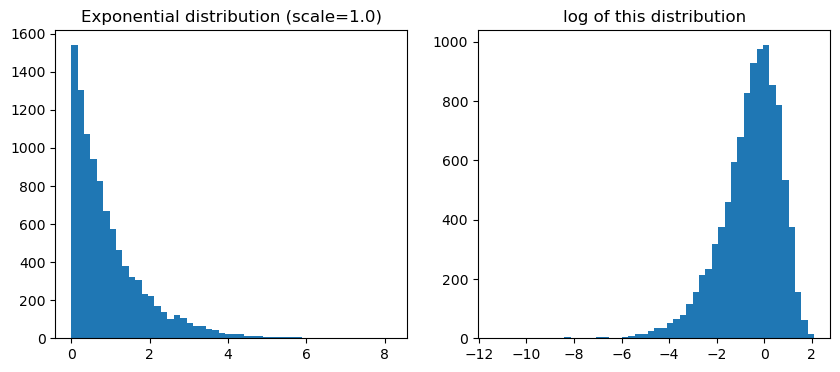

In [103]:
expon_distrib = expon(scale=1.0)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Exponential distribution (scale=1.0)')
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title('log of this distribution')
plt.hist(np.log(samples), bins=50)
plt.show()

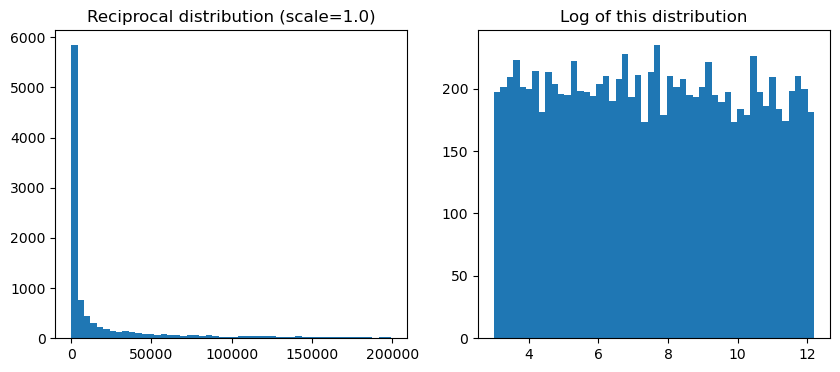

In [104]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [105]:
# 특성 선택하는 변환기

from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr,k):
    # argpartition - partition된 인덱스 반환?
    # np.argpartition(array - 부분적으로 정렬하고자 하는 넘파이 배열, k - 작은 값 k개)
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [111]:
k = 5

In [107]:
top_k_feature_indices = indices_of_top_k(feature_importances, 5)
top_k_feature_indices

array([ 0,  7,  9, 10, 12], dtype=int64)

In [108]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'], dtype='<U18')

In [110]:
sorted(zip(feature_importances, attributes), reverse=True)[:5]

[(0.31671328386159014, 'median_income'),
 (0.15766598026386142, 'INLAND'),
 (0.10569184245927904, 'pop_per_hhold'),
 (0.0767614711132634, 'bedrooms_per_room'),
 (0.07578347449742265, 'longitude')]

In [112]:
preperation_and_feature_selection_pipeline = Pipeline([('preperation', full_pipeline),('feature_selection', TopFeatureSelector(feature_importances, k))])

In [113]:
housing_prepared_top_k_features = preperation_and_feature_selection_pipeline.fit_transform(housing)

In [114]:
housing_prepared_top_k_features[0:3]

array([[-0.94135046, -0.8936472 ,  0.00622264, -0.12112176,  1.        ],
       [ 1.17178212,  1.292168  , -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.52543365, -0.07537122, -0.33827252,  1.        ]])

In [115]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046, -0.8936472 ,  0.00622264, -0.12112176,  1.        ],
       [ 1.17178212,  1.292168  , -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.52543365, -0.07537122, -0.33827252,  1.        ]])

In [116]:
# 파이프라인

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [117]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(...
                 TopFeatureSelector(feature_importances=array([7.57834745e-02, 7.01021708e-02, 4.17004746e-02, 1.71194796e-02,
       1.69712699e-02, 1.73446763e-02, 1.57663143e-02, 3.16713284e-01,
       7.13240476e-02, 1.05691842e-01, 7.67614711e-02, 1.08216214e-02,
       1.57665980e-01, 5.34078302e-05, 2.12738624e-03, 4.05309918e-03]),
                                    k=5)),
                ('svm_reg',
                 SVR(C=157055.10989448498, gamma=0.26497040005002437))])

In [118]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 82915.77062052 288057.72329294  95680.82648363 149790.34263836]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


In [121]:
# 준비단계 옵션 탐색

full_pipeline.named_transformers_['cat'].handle_unknown = 'ignore'
param_grid = [{'preparation__num__imputer__strategy': ['mean', 'median','most_frequent'],
              'feature_selection__k': list(range(1, len(feature_importances)+1))}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                               scoring='neg_mean_squared_error', verbose = 2 , n_jobs=-1)

grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\DMCCONET\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DMCCONET\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DMCCONET\anaconda3\envs\myenv\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\DMCCONET\anaconda3\envs\myenv\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = f

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_inc...
       7.13240476e-02, 1.05691842e-01, 7.67614711e-02, 1.08216214e-02,
       1.57665980e-01, 5.34078302e-05, 2.12738624e-03, 4.05309918e-03]),
                                                           k=5)),
                                       ('svm_reg',
                                        SVR(C=157055.10989448498,
                                            gamma=0.26497040005002437))]),
             n_jobs=-1,
             param_grid=[{'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16],
                          'preparation__num__imputer__strategy': ['mean',
                                                                  'median',
                                                                  'most_frequent']}],
             scoring='neg_mean_squared_error', verbose=2)

In [125]:
grid_search_prep.best_params_

{'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'mean'}